In [2]:
import numpy as np
import qiskit 
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

%matplotlib inline

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')


In [3]:
%matplotlib
%matplotlib

Using matplotlib backend: agg
Using matplotlib backend: agg


In [4]:
# https://arxiv.org/pdf/2011.10860.pdf

In [5]:
circuit_1 = QuantumCircuit(1,1)
circuit_1.h(0)
circuit_1.h(0)
circuit_1.measure(0,0)
_ = circuit_1.draw('mpl')

In [6]:
circuit_2 = QuantumCircuit(1,1)
circuit_2.x(0)
circuit_2.h(0)
circuit_2.h(0)
circuit_2.measure(0,0)
_ = circuit_2.draw('mpl')

In [7]:
circuit_3 = QuantumCircuit(1,1)
circuit_3.y(0)
circuit_3.y(0)
circuit_3.measure(0,0)
_ = circuit_3.draw('mpl')

In [8]:
circuit_4 = QuantumCircuit(1,1)
circuit_4.x(0)
circuit_4.y(0)
circuit_4.y(0)
circuit_4.measure(0,0)
_ = circuit_4.draw('mpl')

In [9]:
def run_circuit(circuit):
    # Use Aer's qasm_simulator
    backend_sim = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    SHOTS = 1024
    job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=1024)

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts()
    
    freq_0 = 0.
    freq_1 = 0.
    for k,v in sorted(counts.items()):
        if k == '0':
            freq_0 = v / SHOTS
        if k == '1':
            freq_1 = v / SHOTS

    
    return freq_0, freq_1
    

In [10]:
v1, v2 = run_circuit(circuit_1)
v3, v4 = run_circuit(circuit_2)
v5, v6 = run_circuit(circuit_3)
v7, v8 = run_circuit(circuit_4)

V = [v1, v2, v3, v4, v5, v6, v7, v8]

print(f"V: {V}")

M1 = np.array([[v1, v3],
               [v2, v4]
              ])

M2 = np.array([[v5, v7],
               [v6, v8]
              ])

print("M1:")
print(M1)
print("M2:")
print(M2)

MG = (M1 + M2) / 2
print("MG:")
print(MG)

V: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]
M1:
[[1. 0.]
 [0. 1.]]
M2:
[[1. 0.]
 [0. 1.]]
MG:
[[1. 0.]
 [0. 1.]]


In [11]:
X = np.random.rand(2)
X

array([0.01314835, 0.04691712])

In [12]:
MG @ X

array([0.01314835, 0.04691712])

In [13]:
def cost_function(X, V, M):
    cost = 0
    MX = M @ X  
    for i in range(0, len(V)):
        v = V[i]
        cost += ( v - MX[i] ) ** 2
    return cost

In [14]:
v = [0., 1.0] # das ist die Messung 
# nach der Messung wird optimiert! 
# x ist dann die Lösung! 
cost_function(X, v, MG)

0.9085398481486191

In [15]:
from scipy.optimize import minimize

In [16]:
cons = (
    {'type': 'eq', 'fun': lambda x: sum(x) - 1},
)

In [17]:
bnds = tuple([(0,1) for _ in range(0,2)])

In [18]:
res = minimize(cost_function, X, method='SLSQP', args=(v, MG), constraints=cons, bounds=bnds,
               options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.930380657631324e-32
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2


In [19]:
np.round(res.x,1) # entspricht ungefähr v 

array([0., 1.])

In [20]:
cost_function(res.x, v, MG)

4.930380657631324e-32

In [21]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

In [22]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from shared.QiskitMaxcut import *

In [23]:
import networkx as nx
def generate_butterfly_graph(with_weights=True):
    # Generate a graph of 5 nodes
    # filename = graph_05_06_02_w.txt
    n = 5
    graph = nx.Graph()
    graph.add_nodes_from(np.arange(0, n, 1))
    if with_weights:
        elist = [(0, 3, 9), (0, 4, 6), (1, 2, 9), (1, 4, 10), (2, 4, 7), (3, 4, 7)]
        graph.name = "graph_05_06_02_w"
    else:
        elist = [(0, 3, 1), (0, 4, 1), (1, 2, 1), (1, 4, 1), (2, 4, 1), (3, 4, 1)]
        graph.name = "graph_05_06_02"
    graph.add_weighted_edges_from(elist)
    
    return graph

def generate_sample_graph(with_weights=True):
    # Generate a graph of 5 nodes
    # filename = graph_05_06_02_w.txt
    n = 4
    graph = nx.Graph()
    graph.add_nodes_from(np.arange(0, n, 1))
    elist = [(0, 1, 1), (1, 2, 1), (2, 3, 1), (3, 0, 1)]
    graph.add_weighted_edges_from(elist)
    
    return graph


In [24]:
G = generate_sample_graph() 
max_cut = Maxcut(G,-35)
max_cut.draw()
qubo = max_cut.to_qubo()

In [25]:
qaoa = QAOA(quantum_instance=Aer.get_backend('qasm_simulator'), initial_point=[ 0.39763271, -3.92897117])
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(qubo)
_ = qaoa.ansatz.draw('mpl')

In [26]:
# https://quantumcomputing.stackexchange.com/questions/5769/how-to-calculate-circuit-depth-properly 
(qaoa.ansatz.depth() - 1) / 2

5.0

In [27]:
_=qaoa.ansatz.inverse().draw('mpl')

In [28]:
qaoa.ansatz.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

In [29]:
qaoa._initial_point

[0.39763271, -3.92897117]

In [30]:
qaoa._ansatz_params

[ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])]

In [31]:
param_dict = dict(zip(qaoa._ansatz_params, qaoa._initial_point))  # type: Dict
wave_function = qaoa.ansatz.assign_parameters(param_dict)
_=wave_function.draw('mpl')

In [32]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
qc = wave_function
dag = circuit_to_dag(qc)
layers = list(dag.multigraph_layers())
print(f"Layers: {len(layers)}")
n_remove = 6

# the extra minus 1 since the last layer consists of output nodes (qubits and clbits).
for layer in layers[- n_remove  :]:

    for node in layer:
        if node.type == 'op':
            dag.remove_op_node(node)
                   
new_qc = dag_to_circuit(dag)

_=new_qc.draw('mpl')

Layers: 13


In [33]:
_=new_qc.inverse().draw('mpl')

In [34]:
newqc = new_qc.compose(new_qc.inverse())

In [35]:
_=newqc.draw('mpl')

In [36]:
# (1) circuits erstellen ain 2^N Zuständen -> doppelt und in einem Array 
# (2) Qaoa Ansatz teilen nach layer nicht nach Depth (Rückfrage) danach jeweils an die aus (1) anhängen
# (3) alle ausführen und Ergebnis nicht count sondern freq in Matrix zu sammenfügen -> algo überlegen 
# (4) optimize function aufstellen, Messung vornehmen und testen! Optimizer maxIter=0, weil der sonst die Rechnungen verfälscht! 


In [37]:
import itertools, copy 
def prepare_circuits(n_qubits):
    start_states = list(map(list, itertools.product([0, 1], repeat=n_qubits)))
    #print(start_states)
    circuits = []
    for state in start_states:
        circuit = QuantumCircuit(n_qubits, n_qubits)
        for i,v in enumerate(state):
            if v == 1:
                circuit.x(i)
                
        circuits.append(circuit)
    
    return circuits, copy.deepcopy(circuits)

In [38]:
first_circuits, second_circuits = prepare_circuits(4)
#for c in first_circuits:
#    print(c)

In [39]:
from qiskit.converters import circuit_to_dag, dag_to_circuit


def split(dag_qc, layers):
    for layer in layers:
        for node in layer:
            if node.type == 'op':
                dag_qc.remove_op_node(node)
    
    return dag_to_circuit(dag_qc)


def split_circuit(qc):
    layers = list(circuit_to_dag(qc).multigraph_layers())

    # calculate separation point 
    n_remove = 0
    if len(layers) % 2 == 0: # even
        n_remove = len(layers) // 2
    else: # odd 
        n_remove = (len(layers) - 1) // 2
        
    # split circuits
    # https://quantumcomputing.stackexchange.com/a/13824/16704 : 
    # the extra minus 1 since the last layer consists of output nodes (qubits and clbits).
    first_half_qc = split(circuit_to_dag(qc), layers[- n_remove -1 :])
    second_half_qc = split(circuit_to_dag(qc), layers[:- n_remove -1])
         
    return first_half_qc, second_half_qc
    

In [40]:
first, second = split_circuit(wave_function)

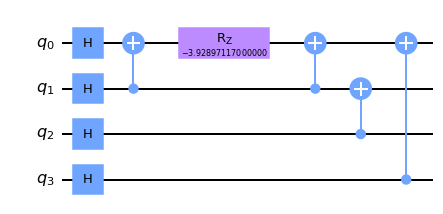

In [41]:
first.draw('mpl')

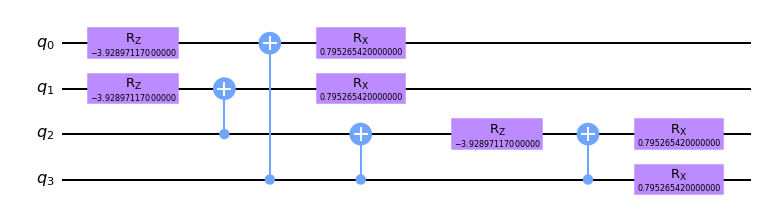

In [42]:
second.draw('mpl')

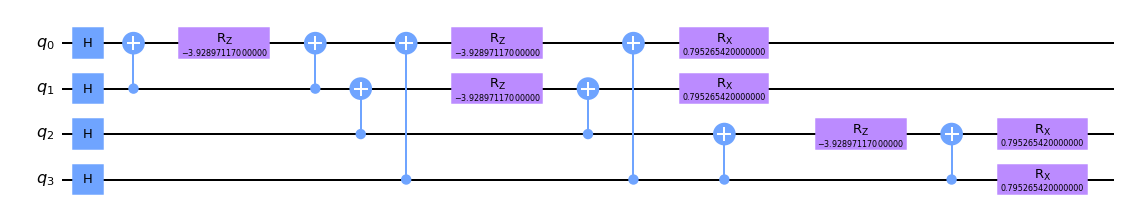

In [43]:
wave_function.draw('mpl')

In [44]:
def inverse_and_compose(circuit):
    return circuit.copy().compose(circuit.inverse())

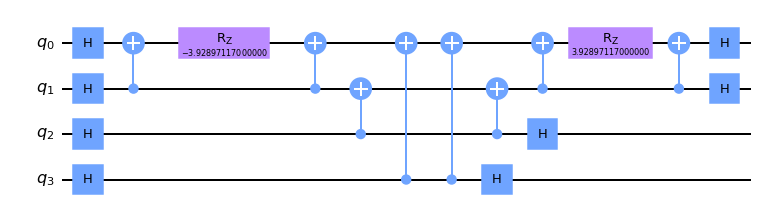

In [45]:
first_inversed = inverse_and_compose(first)
first_inversed.draw('mpl')

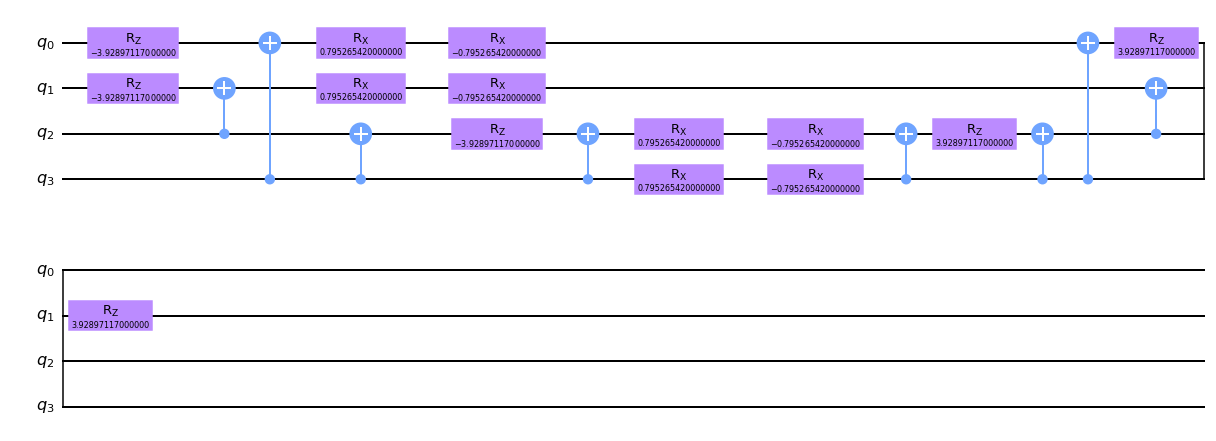

In [46]:
second_inversed = inverse_and_compose(second)
second_inversed.draw('mpl')

In [47]:
def compose_circuits(prepared, inversed):
    qcs = []
    for pc in prepared:
        qc = pc.copy().compose(inversed)
        qc.measure_all()
        
        qcs.append(qc.copy())
        
    return qcs

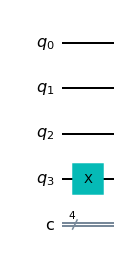

In [48]:
first_circuits[1].draw('mpl')

In [49]:
first_half_composed = compose_circuits(first_circuits, first_inversed)
second_half_composed = compose_circuits(second_circuits, second_inversed)

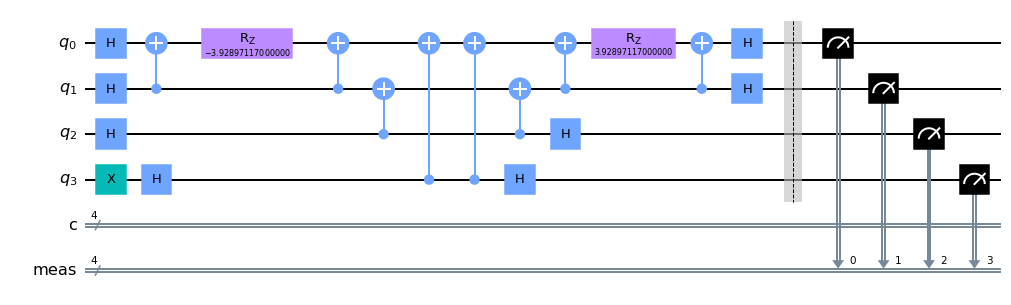

In [50]:
first_half_composed[1].draw('mpl')

In [51]:
#def run_all(circuits):
backend_sim = provider.get_backend('ibmq_toronto')
#circuits = first_half_composed #+ second_half_composed
#circuits = circuits[0:2]
SHOTS = 1024
#job_sim = backend_sim.run(transpile(first_half_composed, backend_sim), shots=SHOTS)
job_sim = backend_sim.retrieve_job('613229b41b943550460ffa89')
# Grab the results from the job.
result_sim = job_sim.result()

In [52]:
#import qiskit.result.ProbDistribution
len(result_sim.results)
#ProbDistribution(result_sim.results[0].get_counts(), SHOTS)

16

In [53]:
def _hex_to_bin(hexstring):
    """Convert hexadecimal readouts (memory) to binary readouts."""
    return str(bin(int(hexstring, 16)))[2:]

def _pad_zeros(bitstring, memory_slots):
    """If the bitstring is truncated, pad extra zeros to make its
    length equal to memory_slots"""
    return format(int(bitstring, 2), f"0{memory_slots}b")

def _separate_bitstring(bitstring, creg_sizes):
    """Separate a bitstring according to the registers defined in the result header."""
    substrings = []
    running_index = 0
    for _, size in reversed(creg_sizes):
        substrings.append(bitstring[running_index : running_index + size])
        running_index += size
    return " ".join(substrings)

def format_counts_memory(shot_memory, header=None):
    """
    Format a single bitstring (memory) from a single shot experiment.
    - The hexadecimals are expanded to bitstrings
    - Spaces are inserted at register divisions.
    Args:
        shot_memory (str): result of a single experiment.
        header (dict): the experiment header dictionary containing
            useful information for postprocessing. creg_sizes
            are a nested list where the inner element is a list
            of creg name, creg size pairs. memory_slots is an integers
            specifying the number of total memory_slots in the experiment.
    Returns:
        dict: a formatted memory
    """
    if shot_memory.startswith("0x"):
        shot_memory = _hex_to_bin(shot_memory)
    if header:
        creg_sizes = header.creg_sizes
        memory_slots = header.memory_slots
        if memory_slots:
            shot_memory = _pad_zeros(shot_memory, memory_slots)
        if creg_sizes and memory_slots:
            shot_memory = _separate_bitstring(shot_memory, creg_sizes)
    return shot_memory

def my_format_counts(counts, header=None):
    """Format a single experiment result coming from backend to present
    to the Qiskit user.
    Args:
        counts (dict): counts histogram of multiple shots
        header (dict): the experiment header dictionary containing
            useful information for postprocessing.
    Returns:
        dict: a formatted counts
    """
    counts_dict = {}
    for key, val in counts.items():
        key = format_counts_memory(key, header)
        counts_dict[key] = val
    return counts_dict

In [58]:
import re

def calculate_freq(result):
    n = len(result.header.clbit_labels)//2
    #print(n)
    shots = result.shots
    combinations = list(map(list, itertools.product([0, 1], repeat=n)))
    freqs = {}
    for comb in combinations: # init dict
        freqs[re.sub('[^01]', '', str(comb))] = 0.0
    
    counts = my_format_counts(result.data.counts, result.header)
    for count in counts.items():
        bitstr, values = count
        if (bitstr == '0'):
            bitstr = '0'*n
        bitstr = bitstr.replace(' ','')
        bitstr = bitstr[:n][::-1]
        freqs[bitstr] = values / shots
    
    return list(freqs.values())

def create_m(results):
    m = np.expand_dims( np.array(calculate_freq(results[0])), axis=1)
    for result in results[1:]:
        v = np.expand_dims( np.array(calculate_freq(result)), axis=1)
        m = np.append(m, v, axis=1)
    return m
        

In [56]:
test_r = result_sim.results[2]
print(test_r)
calculate_freq(test_r)

ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 67, '0x10': 23, '0x20': 42, '0x30': 12, '0x40': 461, '0x50': 48, '0x60': 64, '0x70': 38, '0x80': 37, '0x90': 13, '0xa0': 9, '0xb0': 7, '0xc0': 131, '0xd0': 31, '0xe0': 22, '0xf0': 19}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1], ['c', 2], ['c', 3], ['meas', 0], ['meas', 1], ['meas', 2], ['meas', 3]], creg_sizes=[['c', 4], ['meas', 4]], global_phase=0.0, memory_slots=8, metadata={}, n_qubits=27, name='circuit-724', qreg_sizes=[['q', 27]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6], ['q', 7], ['q', 8], ['q', 9], ['q', 10], ['q', 11], ['q', 12], ['q', 13], ['q', 14], ['q', 15], ['q', 16], ['q', 17], ['q', 18], ['q', 19], ['q', 20], ['q', 21], ['q', 22], ['q', 23], ['q', 24], ['q', 25], ['q', 26]]), memory=False)
4


[0.0654296875,
 0.0361328125,
 0.4501953125,
 0.1279296875,
 0.041015625,
 0.0087890625,
 0.0625,
 0.021484375,
 0.0224609375,
 0.0126953125,
 0.046875,
 0.0302734375,
 0.01171875,
 0.0068359375,
 0.037109375,
 0.0185546875]

In [59]:
m1 = create_m(result_sim.results)
m1

array([[0.3984375 , 0.15722656, 0.06542969, 0.03613281, 0.06054688,
        0.03027344, 0.04980469, 0.02441406, 0.11425781, 0.04882812,
        0.02832031, 0.00976562, 0.05273438, 0.01757812, 0.01660156,
        0.01171875],
       [0.13378906, 0.3671875 , 0.03613281, 0.06542969, 0.03417969,
        0.07421875, 0.01367188, 0.03320312, 0.03320312, 0.08398438,
        0.02050781, 0.03027344, 0.01074219, 0.03417969, 0.01367188,
        0.01269531],
       [0.08398438, 0.03515625, 0.45019531, 0.17382812, 0.04882812,
        0.02929688, 0.09082031, 0.04296875, 0.02929688, 0.01660156,
        0.08886719, 0.05566406, 0.01953125, 0.01171875, 0.04785156,
        0.02929688],
       [0.03417969, 0.08496094, 0.12792969, 0.40527344, 0.02246094,
        0.04882812, 0.02734375, 0.06835938, 0.015625  , 0.03125   ,
        0.04199219, 0.08007812, 0.00878906, 0.01855469, 0.02441406,
        0.03222656],
       [0.04882812, 0.0390625 , 0.04101562, 0.01855469, 0.41992188,
        0.16308594, 0.06640625, 

In [60]:
#def run_all(circuits):
backend_sim = provider.get_backend('ibmq_toronto')
circuits = second_half_composed
#circuits = circuits[0:2]
SHOTS = 1024
job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)
# job id: 61322c1f03ea36031fe8e6b1 
# Grab the results from the job.
result_sim = job_sim.result()

In [61]:
m2 = create_m(result_sim.results)
m2

array([[0.79199219, 0.13867188, 0.08691406, 0.01757812, 0.02636719,
        0.00488281, 0.00488281, 0.        , 0.10839844, 0.03417969,
        0.01367188, 0.00683594, 0.0078125 , 0.015625  , 0.00195312,
        0.00292969],
       [0.07519531, 0.6328125 , 0.0078125 , 0.07324219, 0.00292969,
        0.015625  , 0.        , 0.00097656, 0.01269531, 0.06445312,
        0.00292969, 0.00878906, 0.01171875, 0.00488281, 0.00097656,
        0.00292969],
       [0.02832031, 0.00390625, 0.69726562, 0.12207031, 0.00195312,
        0.        , 0.01757812, 0.00097656, 0.00976562, 0.00683594,
        0.09277344, 0.03125   , 0.00097656, 0.00097656, 0.00683594,
        0.00683594],
       [0.00390625, 0.02734375, 0.0546875 , 0.57421875, 0.        ,
        0.        , 0.00097656, 0.01074219, 0.00292969, 0.00585938,
        0.0078125 , 0.05957031, 0.00390625, 0.00292969, 0.0078125 ,
        0.0078125 ],
       [0.03125   , 0.00390625, 0.03613281, 0.00683594, 0.77734375,
        0.15429688, 0.13085938, 

In [62]:
MG = (m1 + m2) / 2
MG

array([[0.59521484, 0.14794922, 0.07617188, 0.02685547, 0.04345703,
        0.01757812, 0.02734375, 0.01220703, 0.11132812, 0.04150391,
        0.02099609, 0.00830078, 0.03027344, 0.01660156, 0.00927734,
        0.00732422],
       [0.10449219, 0.5       , 0.02197266, 0.06933594, 0.01855469,
        0.04492188, 0.00683594, 0.01708984, 0.02294922, 0.07421875,
        0.01171875, 0.01953125, 0.01123047, 0.01953125, 0.00732422,
        0.0078125 ],
       [0.05615234, 0.01953125, 0.57373047, 0.14794922, 0.02539062,
        0.01464844, 0.05419922, 0.02197266, 0.01953125, 0.01171875,
        0.09082031, 0.04345703, 0.01025391, 0.00634766, 0.02734375,
        0.01806641],
       [0.01904297, 0.05615234, 0.09130859, 0.48974609, 0.01123047,
        0.02441406, 0.01416016, 0.03955078, 0.00927734, 0.01855469,
        0.02490234, 0.06982422, 0.00634766, 0.01074219, 0.01611328,
        0.02001953],
       [0.04003906, 0.02148438, 0.03857422, 0.01269531, 0.59863281,
        0.15869141, 0.09863281, 

In [63]:
v_input = [0.25] + [0.25] + 12 * [0] + [0.25] + [0.25]
v_input

[0.25, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0.25]

In [64]:
X = np.random.rand((16))
X

array([0.40702859, 0.95974453, 0.42166113, 0.82651957, 0.21580087,
       0.43488465, 0.41554733, 0.47880249, 0.71294379, 0.75261474,
       0.91001614, 0.58564618, 0.43872955, 0.24519346, 0.70930312,
       0.82030093])

In [65]:
sum(X)

9.334737071312535

In [66]:
cons = (
    {'type': 'eq', 'fun': lambda x: sum(x) - 1},
)

In [67]:
bnds = tuple([(0,1) for _ in range(0,16)])


In [239]:
res = minimize(cost_function, X, method='SLSQP', args=(v_input, MG), constraints=cons, bounds=bnds,
               options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.8090862278165731e-10
            Iterations: 5
            Function evaluations: 87
            Gradient evaluations: 5


In [240]:
res.x

array([2.49990298e-01, 2.49993342e-01, 3.10890897e-06, 6.78906492e-21,
       3.19664662e-07, 8.72512231e-19, 3.01009131e-06, 2.57784264e-06,
       2.78804014e-06, 7.90417673e-07, 2.64156129e-06, 1.90687104e-07,
       0.00000000e+00, 0.00000000e+00, 2.50001218e-01, 2.49999714e-01])

In [241]:
sum(res.x)

1.0

In [242]:
np.round(res.x, 2)

array([0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.25, 0.25])

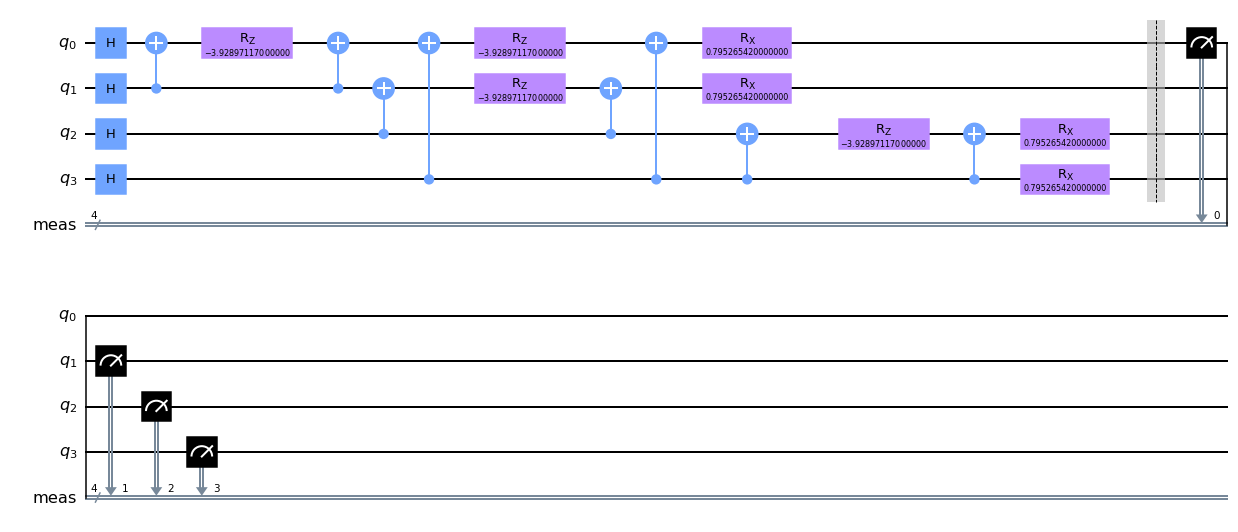

In [70]:
ww = wave_function.copy()
ww.measure_all()
ww.draw('mpl')

In [79]:
#def run_all(circuits):
backend_sim = Aer.get_backend('qasm_simulator')
circuits = second_half_composed
#circuits = circuits[0:2]
SHOTS = 1024
job_sim = backend_sim.run(transpile(ww, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

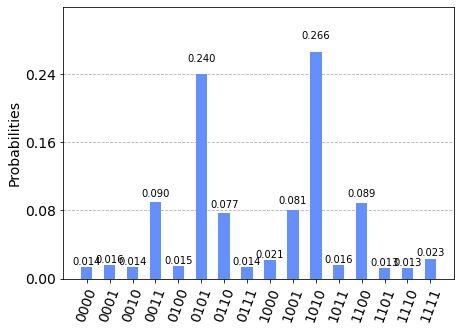

In [80]:
plot_histogram(result_sim.get_counts())

In [81]:
np.sum(list(result_sim.get_counts().values()))

1024

In [82]:
v_new = []
counts = result_sim.get_counts()
for key in sorted(result_sim.get_counts()):
    v_new.append( counts[key] / SHOTS )
v_new

[0.013671875,
 0.015625,
 0.013671875,
 0.08984375,
 0.0146484375,
 0.240234375,
 0.0771484375,
 0.013671875,
 0.021484375,
 0.0810546875,
 0.265625,
 0.015625,
 0.0888671875,
 0.0126953125,
 0.0126953125,
 0.0234375]

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS
Number of samples (16) is too large to display. Skip.
Expectation Value: -3.046875
Highest Exp.Value: 0 with 2.5391 %
Lowest Exp.Value: -4 with 54.883 %
Highest Probability: -4 with 54.883 %
Ratio r: 0.76171875
Approiximation ratio: 0.08705357142857142
MSE: 3.7626139322916665
RMSE: 1.939745842189555


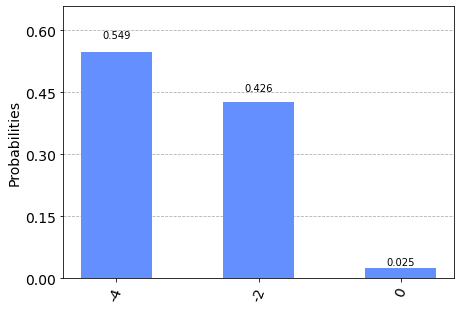

In [101]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, QNSPSA
qaoa1 = QAOA(quantum_instance=Aer.get_backend('qasm_simulator'), optimizer=COBYLA(maxiter=100))
algorithm1 = MinimumEigenOptimizer(qaoa1)
result1 = algorithm1.solve(qubo)
result1.raw_samples
mean, distribution = max_cut.analyse(result1, print_output=True)
plot_histogram(distribution)

In [300]:
qaoa1.optimal_params

array([ 0.39763271, -3.92897117])

In [6]:
#def run_all(circuits):
backend_sim = provider.get_backend('ibmq_toronto')
#circuits = second_half_composed
#circuits = circuits[0:2]
SHOTS = 1024
#job_sim = backend_sim.run(transpile(ww, backend_sim), shots=1024)
job_sim = backend_sim.retrieve_job('61322cfc30f13e195c88dce4')
# Grab the results from the job.
result_sim = job_sim.result()

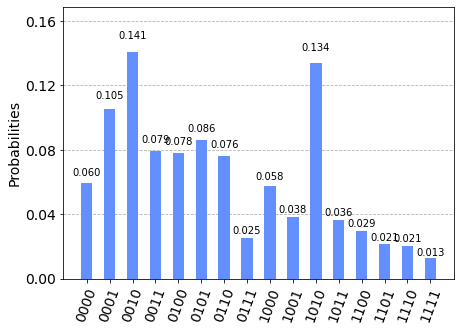

In [7]:
plot_histogram(result_sim.get_counts())

In [8]:
v_new_noise = []
counts = result_sim.get_counts()
for key in sorted(result_sim.get_counts()):
    v_new_noise.append( counts[key] / SHOTS )
v_new_noise

[0.0595703125,
 0.10546875,
 0.140625,
 0.0791015625,
 0.078125,
 0.0859375,
 0.076171875,
 0.025390625,
 0.0576171875,
 0.0380859375,
 0.1337890625,
 0.0361328125,
 0.029296875,
 0.021484375,
 0.0205078125,
 0.0126953125]

In [88]:
res = minimize(cost_function, X, method='SLSQP', args=(v_new_noise, MG), constraints=cons, bounds=bnds,
               options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.370177449493958e-05
            Iterations: 8
            Function evaluations: 136
            Gradient evaluations: 8


In [121]:
np.round(res.x,2)

1.0000000000000002

In [90]:
x_noise = res.x * 1024

In [96]:
np.sum(np.round(x_noise,2))

1024.0

In [97]:
counts_noise = []
counts = result_sim.get_counts()
i = 0
for key in sorted(result_sim.get_counts()):
    counts[key] = np.round(x_noise[i],2)
    i  += 1
counts

{'0000': 5.37,
 '0001': 167.05,
 '0010': 166.44,
 '0011': 89.44,
 '0100': 50.13,
 '0101': 132.72,
 '0110': 91.09,
 '0111': 0.0,
 '1000': 39.55,
 '1001': 22.86,
 '1010': 242.14,
 '1011': 0.25,
 '1100': 5.54,
 '1101': 11.42,
 '1110': 0.0,
 '1111': 0.0}

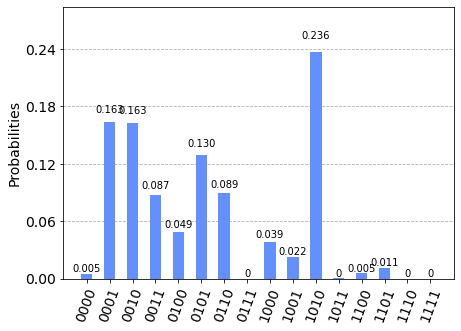

In [98]:
plot_histogram(counts)

In [ ]:
#def run_all(circuits):
backend_sim = provider.get_backend('ibmq_toronto')
circuits = second_half_composed
#circuits = circuits[0:2]
SHOTS = 1024
job_sim = backend_sim.run(transpile(ww, backend_sim), shots=1024)
job_sim = backend_sim.retrieve_job('61322cfc30f13e195c88dce4')
# Grab the results from the job.
result_sim = job_sim.result()

In [11]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [13]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(4)
qubit_list = [0,1,2,3]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [9]:
# Execute the calibration circuits without noise
backend = provider.get_backend('ibmq_toronto')
#job = qiskit.execute(meas_calibs, backend=backend, shots=1024)
job = backend_sim.retrieve_job('613232b361ab237f86beadbe')
# 613232b361ab237f86beadbe
cal_results = job.result()

In [21]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list,circlabel='mcal')

In [22]:
# Get the filter object
meas_filter = meas_fitter.filter

In [27]:
# Results with mitigation
mitigated_results = meas_filter.apply(result_sim, 'least_squares')
mitigated_counts = mitigated_results.get_counts(0)

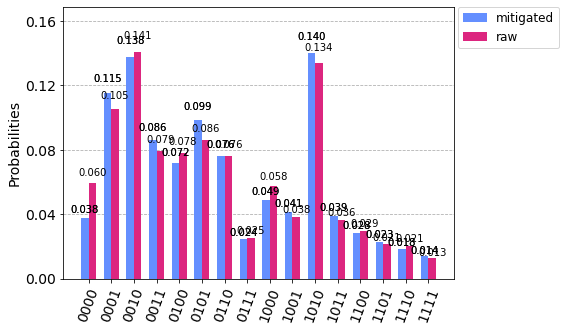

In [26]:
plot_histogram([mitigated_counts, result_sim.get_counts()], legend=['mitigated','raw'])

In [124]:
sasdf